# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Nicola Visentin"
STUDENT_1_STUDENT_NUMBER = "6354815"
STUDENT_1_NETID = "nvisentin"
STUDENT_1_EMAIL = "N.Visentin@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 1b - Vision-based angle prediction (20 points)

**Authors:** Chuhan Zhang (C.Zhang-8@tudelft.nl), Tomás Coleman, Maximilian Stölzle

**Warning** To help you, we have marked parts of the code where we want you to contribute. These parts are often marked with a start comment, `Task 1b.i.j: ...` and a closing comment, `Task 1b.i.j: END`. You are free to add code outside of the designated areas. However, we cannot guarantee that this won't affect the intended behavior of the code.

In this file, we will implement two Convolutional Neural Network (CNN) models to predict the position of the single pendulum based on input image data. Each CNN model will try a separate way to predict angles: direct or indirect. Direct prediction means that the network outputs a prediction of the link angle $\hat \theta$, and then updates the network parameters by comparing the loss between the predicted $\hat \theta$ and the label $\theta$. However, indirect prediction means that the dataset has changed. Label is no longer a single angle, but an array containing the $\sin \theta$ value and $\cos \theta$ value of the angle. The output of the network is no longer a single $\hat \theta$, but the predicted $[\hat {\sin \theta}, \hat {\cos \theta}]$. The network updates parameters by comparing the loss between $[\sin \theta, \cos \theta]$ and $[\hat {\sin \theta}, \hat {\cos \theta}]$.

The following cells import all the necessary packages and external functions to run the code properly. First, we want to check whether the images are generated properly and create the directory for output plots and models. Different dataset classes are also created from the information gathered in notebook 1a. Finally, different Pytorch data loaders will be created for each network architecture.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import PathLike
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
from tqdm.notebook import tqdm  # progress bar
from typing import List, Tuple
from distutils.util import strtobool

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))


# seed the random number generators
# https://pytorch.org/docs/stable/notes/randomness.html
def manual_seed(seed: int):
    """
    Set manual seeds

    Args:
        seed: Random seed to sett.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)


class DirectoryNotFoundException(Exception):
    """
    Exception raised when a specified directory is not found.

    This exception is used to signal that an operation which expects
    a certain directory to exist has failed because the directory
    was not found in the expected location. It extends the standard
    Exception class and can be used to provide more specific error
    handling that is distinct from general exceptions.

    Attributes:
        None - Inherits all attributes and methods from the base Exception class.

    Methods:
        None - Inherits all methods from the base Exception class and does not
        define any additional behavior.
    """

    pass


class ModelTypeNotFoundException(Exception):
    """
    Exception raised when a specified model type is not found.

    This exception is used in contexts where a specific type of
    model is expected to be present or accessible, but it cannot
    be located or identified. The exception is particularly useful
    in scenarios involving machine learning or data processing
    pipelines where the absence of a required model type can lead
    to failure of the process.

    Attributes:
        None - Inherits all attributes and methods from the base Exception class.

    Methods:
        None - Inherits all methods from the base Exception class and does not
        define any additional behavior.
    """

    pass


# check the directory for datasets
DATASET_DIR = Path("datasets") / "pendulum_dataset"
if not DATASET_DIR.exists():
    raise DirectoryNotFoundException(
        f"The pendulum dataset doesn't exist yet. Please run all cells in the `task_1a_extract_dataset` notebook."
    )

# create the directory for well-trained neural network models
STATEDICTS_DIR = Path("statedicts")
STATEDICTS_DIR.mkdir(parents=True, exist_ok=True)

Then, we would like to prepare the training and test sets for the CNNs. In this assignment, we use two ways to predict the state: direct and indirect. Therefore, we prepare the datasets with two formats of labels, called $theta$ and $trig$ respectively.

In [4]:
class CNNDataset(Dataset):
    """
    A PyTorch dataset class for a CNN, designed to load images and corresponding labels.

    This class extends the PyTorch Dataset class, making it suitable for use with
    PyTorch data loaders and other utilities. It is designed to load image data
    and their associated labels from a specified directory, performing optional
    transformations on the images.
    """

    def __init__(self, dataset_path: PathLike, transform=None):
        """
        Initializes the dataset object with the data path, optional transform, and dataset length.

        Args:
            dataset_path: Path to the directory where image and label files are stored.
            transform: A function/transform that takes in an image and returns a transformed version.
        """

        self.dataset_path = Path(dataset_path)
        self.transform = transform

        # determine the total dataset length
        i = 0
        while (self.dataset_path / f"image{i}.npz").exists():
            i += 1
        self.len = i

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves an image and its corresponding label at the given index `idx`. The image is
        loaded from a .npz file, optionally transformed, and then returned along with its label
        (both in position form and as sine and cosine components).

        Args:
            idx: The index of the image and label to be loaded.
        Returns:
            x: The image as a torch.Tensor, possibly transformed.
            label_theta: The position label as a torch.FloatTensor
            label_trig: A torch.FloatTensor with two elements, representing the sine and cosine
               components of the label.
        """
        x = np.array(np.load(self.dataset_path / f"image{idx}.npz")["arr_0"])
        if self.transform:
            x = self.transform(x)
        theta = np.load(self.dataset_path / f"label{idx}.npz")["arr_0"]
        sin = np.sin(theta)
        cos = np.cos(theta)

        theta = torch.tensor(np.array(theta)).type(torch.FloatTensor)
        trig = torch.tensor(np.array([sin, cos])).type(torch.FloatTensor)
        return x, theta, trig

    def __len__(self) -> int:
        """
        Returns the total number of samples available in the dataset.

        Returns:
            self.len: The total number of images (or samples) in the dataset.
        """
        return self.len

The size of the original image data is `500x500x3`, and we want to compress it into a smaller size to save the computation time. Therefore, we add _transforms_ for preprocessing data when building our `Dataset` object. We first use the `ToTensor()` method in PyTorch to convert pixel data distributed between `[0, 255]` into floating point tensor data distributed between `[0, 1]`. Then, we use `Grayscale()` to convert the RGB images into grayscale images. _**Optional question**: Why can we convert the input color image into a grayscale image in this task? Can this be done for all tasks?_ Then we use `CenterCrop()` to extract the center `240x240`px area of the original image, and use `Resize()` to downsample the image to `24x24`px. With this preprocessing pipeline, we obtained training data with each input sample being a tensor of dimension `24x24x1`.

In [5]:
IMAGE_TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.CenterCrop(240),
        transforms.Resize((24, 24)),
    ]
)

It is worth noting that, this `DataLoader` returns three variables: the image $x$, the corresponding label $\theta$, and $[\sin \theta, \cos \theta]$ data. The `DataLoader` is consistent for direct and indirect prediction tasks. You must be careful about using underscores in your code to ignore unnecessary return values for the task.

In this task, we divide the entire data set into three parts: training set, validation set, and test set. The split ratio between training, validation, and testing is 50%, 20%, and 30%. By calling the `load_dataloaders` method, the data loaders for training, validation, and testing are provided.

In [6]:
def load_dataloaders(
    dataset_path: PathLike,
    val_ratio: float = 0.2,
    test_ratio: float = 0.3,
    batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Loads and returns data loaders for training, validation, and testing datasets.

    Args:
        dataset_path: Path to the directory where the dataset is stored.
        val_ratio: The ratio of the dataset to be used for validation.
                    It must be between 0 and 1. Defaults to 0.2.
        test_ratio: The ratio of the dataset to be used for testing.
                    It must be between 0 and 1. Defaults to 0.3.
        batch_size: The number of samples per batch to load. Defaults to 32.

    Returns:
        train_dataloader: The DataLoader instances for the training.
        val_dataloader: The DataLoader instances for the validation.
        test_dataloader: The DataLoader instances for the testing.

    Raises:
        AssertionError: If the sum of val_ratio and test_ratio is larger than 1.0
    """
    assert (
        0.0 <= val_ratio <= 1.0
    ), "Validation ratio needs to be in the interval [0, 1]."
    assert 0.0 <= test_ratio <= 1.0, "Test ratio needs to be in the interval [0, 1]."
    assert (
        val_ratio + test_ratio
    ) <= 1.0, "The sum of val and test ratio needs to be in the interval [0, 1]."

    dataset = CNNDataset(dataset_path, transform=IMAGE_TRANSFORM)
    print(f"The dataset contains {len(dataset)} samples")

    train_size = int(len(dataset) * (1.0 - val_ratio - test_ratio))
    val_size = int(len(dataset) * val_ratio)
    test_size = int(len(dataset) * test_ratio)

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )

    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader


train_loader, val_loader, test_loader = load_dataloaders(DATASET_DIR)

The dataset contains 3600 samples


We show the data after preprocessing as below. Do you still remember the colorful, high-resolution dataset samples in task 1a? Now, they have become a low-resolution grayscale image. Please feel free to visualize multiple samples by changing the respective `sample_idx` variable.

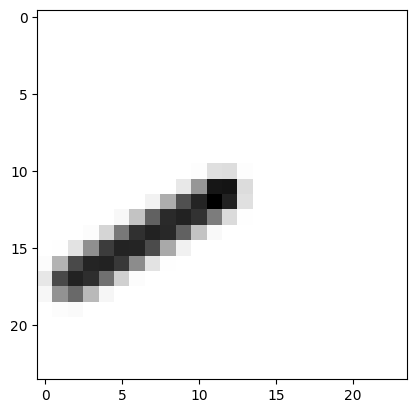

In [7]:
def visualize_dataset_sample(dataset_path: str, sample_idx: int = 1200) -> None:
    """
    Displays a visual representation of an example image from the dataset.

    Args:
        dataset_path: Path to the directory where the dataset is stored.
        sample_idx: The index of the sample to be visualized. Defaults to 1200.

    Returns:
        None: This function only displays an image and does not return any value.
    """
    dataset = CNNDataset(dataset_path, transform=IMAGE_TRANSFORM)
    img_example, _, _ = dataset[sample_idx]
    img_example = img_example.permute(1, 2, 0)
    plt.imshow(img_example, cmap="gray")
    plt.show()


visualize_dataset_sample(DATASET_DIR)

We already have the function to build training, validation, and testing dataloaders. We will package the evaluation function in the following code block.

Here, during the process of training, we adopt Mean Square Error (MSE) as the loss by invoking `nn.MSELoss()` from PyTorch. During the evalutation process (also in `evaluate_model` method), we adopt Mean Absolute Error (MAE) as the error by invoking `nn.L1Loss()`. _**Optional question:** why do we use MSE in the training process instead of MAE?_

In [8]:
loss_fn = nn.MSELoss(reduction="mean")
error_fn = nn.L1Loss(reduction="mean")


def evaluate_model(
    model: nn.Module, eval_loader: DataLoader, model_type: str = "theta"
) -> Tuple[float, float]:
    """
    Evaluates the performance of a theta model on a test dataset.

    Args:
        model: The neural network model to be evaluated.
        eval_loader: The DataLoader for the evaluation dataset.
        model_type: The type of model to be evaluated ('theta' or 'trig').
                                    Defaults to 'theta'.

    Returns:
        loss: The mean loss of the model on the valuation dataset.
        error: The mean error of the model on the evaluation dataset.

    Raises:
        ModelTypeNotFoundException: If the provided model_type is neither 'theta' nor 'trig'.

    """
    running_loss = 0.0
    running_error = 0.0
    count = 0.0
    with torch.no_grad():
        for i, (x, theta, trig) in enumerate(eval_loader):
            if model_type == "theta":
                theta_hat = model(x).squeeze(1)

                batch_loss = loss_fn(theta, theta_hat)
                batch_error = error_fn(theta, theta_hat)
            elif model_type == "trig":
                trig_hat = model(x)
                sin_hat = trig_hat[:, 0]
                cos_hat = trig_hat[:, 1]
                sin = trig[:, 0]
                cos = trig[:, 1]
                angle_hat = torch.atan2(sin_hat, cos_hat)
                angle = torch.atan2(sin, cos)

                batch_loss = loss_fn(trig, trig_hat)
                batch_error = error_fn(angle, angle_hat)
            else:
                raise ModelTypeNotFoundException(
                    f"The model type should be either theta or trig."
                )

            running_loss += batch_loss.item()
            running_error += batch_error.item()
            count += 1

    loss = running_loss / count
    error = running_error / count

    return loss, error

## Task 1b.1 - Learn to predict angles directly (9.5 points)
We are going to create models that try to predict the link angles $\hat{\theta}$ given an image of the robot, so $\theta \approx \hat{\theta} =M(x)$.

### Tasb 1b.1.1 - Create the CNN model (3.5 points)
It's time to create a CNN model. Here, create a PyTorch model class called `CNNTheta()`.
* Start with a convolutional layer `torch.nn.Conv2d(...)` with 32 as the output channel number and a kernel size of `3x3`. This convolutional layer should be followed by a ReLU activation function.
* Then add an average pooling layer `torch.nn.AvgPool2d(...)` with a pooling kernel size of `2x2`.
* Add another convolutional layer with `10` as the output channel number and `3x3` as the kernel size. This convolutional layer is also followed by a ReLU function.
* Add another average pooling layer with the kernel size of `2x2`.
* Flatten the output of the pooling layer using `torch.nn.Flatten()`.
* Add a fully connected layer with `30` as the output channel number, with a ReLU activation function.
* Finally, add another fully connected layer without activation function. Remember, the number of output units must match the dimension of the target data, which is 1.

In [9]:
"""TASK 1b.1.1: CREATE THETA MODEL HERE"""
# YOUR CODE HERE #########################################

class CNNTheta(nn.Module):
    def __init__(self, num_in, num_out):
        super().__init__()
        
        # some parameters
        N = 24    # (NxN) image dimension (24)
        nc = 3    # convolution kernel size (3)
        na = 2    # average pooling kernel size (2)

        # activation function
        self.act_fn = nn.ReLU()

        # convolution layer 1. stride = padding = 1 as suggested in the documentation       
        self.convolution1 = nn.Conv2d(num_in, out_channels=32, kernel_size=nc, stride=1, padding=1)
        # filtered image dimension ( floor((24+2-3)/1)+1=24 ) after this layer (does not change)

        # average pooling layer 1. stride = 2 as suggested in the documentation
        self.av_pooling = nn.AvgPool2d(kernel_size=na, stride=2)
        N = int(np.floor((N-na)/2)+1)  # filtered image dimension ((24-2)/2+1=12) after this layer

        # convolution layer 2
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=nc, stride=1, padding=1)
        # filtered image dimension ( floor((12+2-3)/1)+1=12 ) after this layer (does not change)
        
        # average pooling layer 2 is applied
        N = int(np.floor((N-na)/2)+1)  # filtered image dimension ((12-2)/2+1=6) after this layer

        # flatten function
        self.flatten = nn.Flatten()
        N = 10*N*N  # flattened image dimension (10 channels * 6 * 6 = 360)

        # linear layers
        self.fully_connected1 = nn.Linear(in_features=N , out_features=30)  
        self.fully_connected2 = nn.Linear(in_features=30 , out_features=num_out)

    def forward(self,x):
        x = self.convolution1(x)
        x = self.act_fn(x)
        x = self.av_pooling(x)
        x = self.convolution2(x)
        x = self.act_fn(x)
        x = self.av_pooling(x)
        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.act_fn(x)
        x = self.fully_connected2(x)
        return x

##########################################################
"""TASK 1b.1.1: END"""

model_theta = CNNTheta(num_in=1, num_out=1)  # 1 input channel (grayscale image) and 1 output channel (predicted theta)
total_params_theta = sum(p.numel() for p in model_theta.parameters())
print("Total number of trainable model parameters: ", total_params_theta)

Total number of trainable model parameters:  14071


### Tasb 1b.1.2 - Train the model (4 points)
Now that the model is defined, we can train it using the training dataset. Train the model for 50 epochs with the training data `train_loader`. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 50 epochs. For each training loop, it would be useful to test the model performance on the validation set to see if it is overfitting the training data or can generalize well. Do this 3 times and use the validation dataset `val_loader` with the function `evaluate_model` to get the validation result. 

**Hints:** 
- When we iterate over the training set, we use `(x, theta, _)` or something similar where `_` is used to ignore `trig`.
- Reduce the number of epochs and lower the number of runs to `1` while getting your model working and setting the optimal learning rate. 
- Try varying the learning rate in the `1e-1` to `1e-5` range.

In [10]:
# set the number of runs (i.e., different random seeds)
num_runs = 3  # Change to 1 until you get it to work once
# number of epochs we train each model for
num_epochs = 50

Starting run 0


  0%|          | 0/50 [00:00<?, ?it/s]

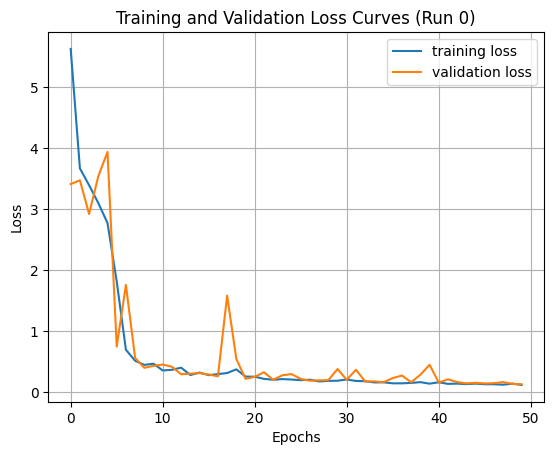

Run 0 finished with a test loss of 0.1151 rad^2 and a mean test error of 0.1014 rad.
Starting run 1


  0%|          | 0/50 [00:00<?, ?it/s]

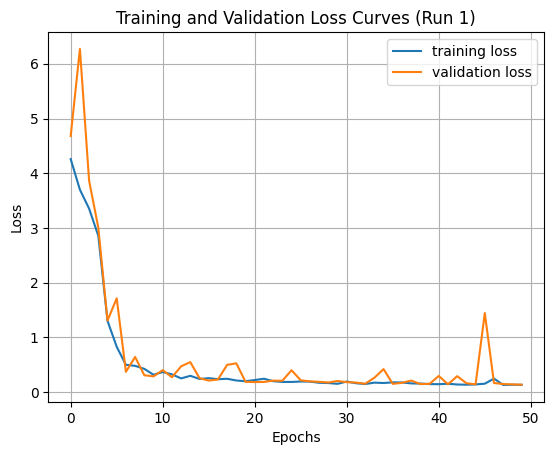

Run 1 finished with a test loss of 0.1326 rad^2 and a mean test error of 0.1208 rad.
Starting run 2


  0%|          | 0/50 [00:00<?, ?it/s]

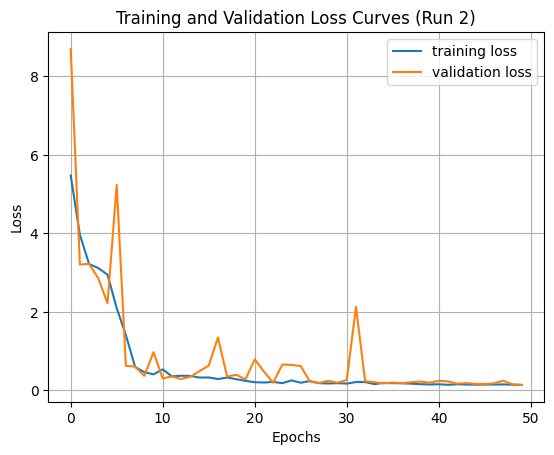

Run 2 finished with a test loss of 0.1321 rad^2 and a mean test error of 0.1189 rad.


In [11]:
if not AUTOGRADING:
    """TASK 1b.1.2: TRAIN MODEL HERE"""
    # YOUR CODE HERE #########################################
    
    for run in range(num_runs):
        # Initialization
        print(f"Starting run {run}")
        manual_seed(seed=run+1)                      # set new random seed
        model_theta = CNNTheta(num_in=1,num_out=1)   # this code reinitializes the parameters of the model on each loop
        
        # Define the optimizer and the learning rate
        optimizer = torch.optim.SGD(model_theta.parameters(), lr=8e-3)

        # Training the model
        epoch_trainlosses = []   # vector containing the mean loss over the training set for each epoch
        epoch_vallosses = []     # vector containing the mean loss over the validation set for each epoch
        model_theta.train()      # set the model to train mode
        
        for epoch in tqdm(range(num_epochs)):
            batch_trainlosses = []                          # vector containing the loss for each batch of the training set
            
            for imags, theta_labels, _ in train_loader:     # iterate over the batches in the train dataset
                # create predictions with the current model for the current batch
                preds = model_theta(imags)
                preds = preds.squeeze(dim=1)

                # compute the loss function with the current model for the current batch
                loss = loss_fn(preds, theta_labels.float())
                batch_trainlosses.append(loss.item())  # store for computing training loss curve

                # optimize the parameters
                optimizer.zero_grad()
                loss.backward()     # compute gradients
                optimizer.step()    # update parameters

            # update epoch loss vectors
            mean_epoch_trainloss = sum(batch_trainlosses) / len(batch_trainlosses)  # compute the mean loss for this epoch
            epoch_trainlosses.append(mean_epoch_trainloss)                          # update train loss vector       
            epoch_valloss, _ = evaluate_model(model_theta, val_loader, model_type="theta")  # compute loss over the validation set for this epoch
            epoch_vallosses.append(epoch_valloss)                                           # update validation loss vector

        # plot loss curves to check overfitting
        plt.figure()
        plt.plot(range(num_epochs), epoch_trainlosses, label=f"training loss")
        plt.plot(range(num_epochs), epoch_vallosses, label=f"validation loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss Curves (Run {run})")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Test the model: evaluate the performances of the run-th training
        run_test_loss, run_test_error = evaluate_model(model_theta, test_loader, model_type="theta")
        print(f"Run {run} finished with a test loss of {run_test_loss:.4} rad^2 and a mean test error of {run_test_error:.4} rad.")

        # Save the model
        torch.save(model_theta.state_dict(), STATEDICTS_DIR / f"task_1b_theta_model_run-{run}.pth", _use_new_zipfile_serialization=False,)
        
    ##########################################################        
    """TASK 1.1.2: END"""

Evaluate the final result on the `test_loader` using the function `evaluate_model`. The `model_type` is `theta` in this situation.

In [12]:
# evaluate the theta model on the test set
test_error_across_runs_theta = np.zeros((num_runs,))
for run in range(num_runs):
    model_theta.load_state_dict(
        torch.load(STATEDICTS_DIR / f"task_1b_theta_model_run-{run}.pth")
    )
    run_test_loss, run_test_error = evaluate_model(
        model_theta, test_loader, model_type="theta"
    )
    test_error_across_runs_theta[run] = run_test_error
print(
    f"Prediction error of theta model across runs: {np.mean(test_error_across_runs_theta):.4} += {np.std(test_error_across_runs_theta):.4} rad."
)

Prediction error of theta model across runs: 0.1137 += 0.008701 rad.


### Tasb 1b.1.3 - Analyse model performance (2 points)
Evaluate the trained model's accuracy by examining the average error in the link angle prediction. Please analyze the training loss curve: does the training loss decrease step by step? (1 point)

$\color{red}{Answer: }$  
Training and validation are performed in parallel over 50 epochs: for each epoch, loss function over the training dataset and loss function over the validation dataset are computed. After the model is trained, we plot the training loss curve (blue) and the validation loss curve (red) as functions of the epochs. Finally, the trained model is tested over the test dataset and saved.
We repeat this entire operation for three times, each time resetting the model and changing the random seed, thus obtaining three models (that should be similar).  
The average error in the link angle prediction is computed by averaging the three errors obtained by evaluating each model over the test dataset. This error is quite small (around 0.1 radians), meaning that the training was succesfull.  
If we analyze the loss curves, we notice that the train loss curve is correctly decreasing, meaning that the model is effectively learning. After a while, this curve becomes "flat", meaning that we may have reached a minimum.
To check for overfitting (i.e. when the model is "learning specifically the train dataset" and not "learning in general to recognise the angle"), we cannot simply rely on the training loss curve, as it is still decreasing even in presence of overfitting. So we need to see how the model evolves using another dataset (validation set). If the validation loss function decreases as well towards the end, then everything is fine.

We always use a separate test dataset to evaluate a trained model. What is the reason for this? (1 point)

$\color{red}{Answer: }$  
In general, we want to evaluate the capability of our trained model to be effective in presence of "new, unseen" data. If we used the same dataset both for training and testing, there would be the risk that the test results extremely accurate not because the model is good, but because the model "learnt very well" the train dataset (overfitting, as we already said). 

## Task 1b.2 - Indirectly predict the angle (10.5 points)
We are going to improve the accuracy by pre-processing the target data. Specifically, we will create a model $M_{trig}$ that learns to predict $\sin(\theta)$ and $\cos(\theta)$ for the pendulum instead of directly predicting $\theta$. Then, we can use the inverse tangent function to retrieve an estimate of $\theta$ for both links.

*Note:* In practice you would use the `atan2` implementation, as the regular arctangent only covers $[-\frac{1}{2}\pi, \frac{1}{2}\pi]$} $\theta=\arctan(\frac{\sin(\theta)}{\cos(\theta)})$ 

### Task 1b.2.1 - Create the model (3.5 points)
Copy the model you created in Task 1.1. Change the number of hidden units of the final layer from 1 to 2. We do so because we now want to predict two outputs ($\sin(\theta)$, $\cos(\theta)$) for each sample. The total number of the model parameters should increase slightly compared to Task 1.1. _**Optional question:** Why does the number of model parameters increase?_

In [13]:
"""TASK 1b.2.1: CREATE TRIGONOMETRIC MODEL HERE"""
# YOUR CODE HERE #########################################

class CNNTrig(nn.Module):
    def __init__(self, num_in, num_out):
        super().__init__()
        
        # some parameters
        N = 24    # (NxN) image dimension (24)
        nc = 3    # convolution kernel size (3)
        na = 2    # average pooling kernel size (2)

        # activation function
        self.act_fn = nn.ReLU()

        # convolution layer 1. stride = padding = 1 as suggested in the documentation       
        self.convolution1 = nn.Conv2d(num_in, out_channels=32, kernel_size=nc, stride=1, padding=1)
        # filtered image dimension ( floor((24+2-3)/1)+1=24 ) after this layer (does not change)

        # average pooling layer 1. stride = 2 as suggested in the documentation
        self.av_pooling = nn.AvgPool2d(kernel_size=na, stride=2)
        N = int(np.floor((N-na)/2)+1)  # filtered image dimension ((24-2)/2+1=12) after this layer

        # convolution layer 2
        self.convolution2 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=nc, stride=1, padding=1)
        # filtered image dimension ( floor((12+2-3)/1)+1=12 ) after this layer (does not change)
        
        # average pooling layer 2 is applied
        N = int(np.floor((N-na)/2)+1)  # filtered image dimension ((12-2)/2+1=6) after this layer

        # flatten function
        self.flatten = nn.Flatten()
        N = 10*N*N  # flattened image dimension (10 channels * 6 * 6 = 360)

        # linear layers
        self.fully_connected1 = nn.Linear(in_features=N , out_features=30)  
        self.fully_connected2 = nn.Linear(in_features=30 , out_features=num_out)

    def forward(self,x):
        x = self.convolution1(x)
        x = self.act_fn(x)
        x = self.av_pooling(x)
        x = self.convolution2(x)
        x = self.act_fn(x)
        x = self.av_pooling(x)
        x = self.flatten(x)
        x = self.fully_connected1(x)
        x = self.act_fn(x)
        x = self.fully_connected2(x)
        return x

##########################################################
"""TASK 1b.2.1: END"""

model_trig = CNNTrig(num_in=1, num_out=2)
total_params_trig = sum(p.numel() for p in model_trig.parameters())
print("total number of model parameters: ", total_params_trig)

total number of model parameters:  14102


### Task 1b.2.2 - Train the model (4 points)
Now train a model with the same training hyperparameters as in task 1.1 but using the the trigonometric labels. When dealing with the return value of the `train_loader,` be careful to make sure that the output is the $[\sin(\theta)$, $\cos(\theta)]$ instead of $\theta$. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 50 epochs. Do this 3 times like the previous task.

**Hint:** 
- We utilize the third instead of the second item in the tuple returned by the dataloader. Therefore, when we iterate over the training set, we use `(x, _, trig)` where `_` is applied to ignore `theta`. Here, `trig` is a tensor containing $\sin$ value and $\cos$ value
- Reduce the number of epochs and lower the number of runs to `1` while getting your model working. 
- Try in the range `1e-1` to `1e-5` for the learning rate

In [14]:
# set the number of runs (i.e., different random seeds)
num_runs = 3  # Change to 1 until you get it to work once
# number of epochs we train each model for
num_epochs = 50

Starting run 0


  0%|          | 0/50 [00:00<?, ?it/s]

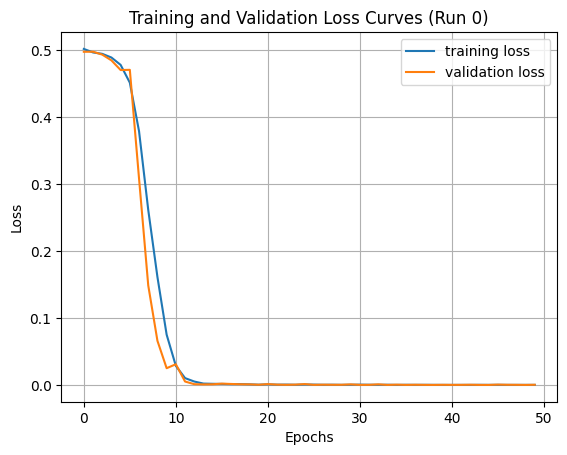

Run 0 finished with a test loss of 0.0003692 rad^2 and a mean test error of 0.03905 rad.
Starting run 1


  0%|          | 0/50 [00:00<?, ?it/s]

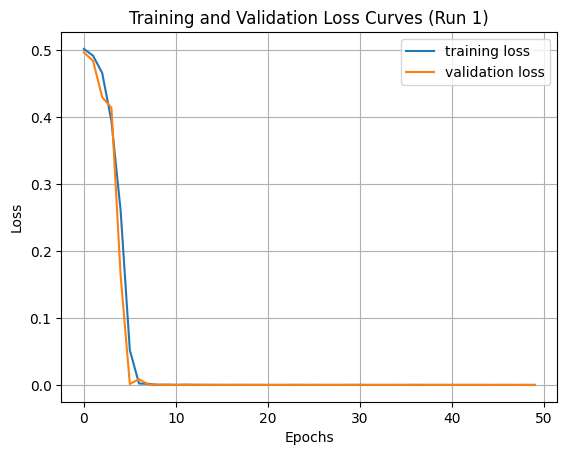

Run 1 finished with a test loss of 7.371e-05 rad^2 and a mean test error of 0.02178 rad.
Starting run 2


  0%|          | 0/50 [00:00<?, ?it/s]

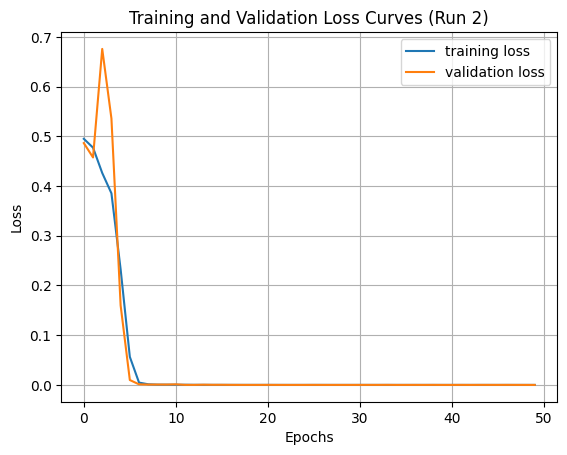

Run 2 finished with a test loss of 5.861e-05 rad^2 and a mean test error of 0.003772 rad.


In [15]:
if not AUTOGRADING:
    """TASK 1b.2.2: TRAIN TRIGONOMETRIC MODEL HERE"""
    # YOUR CODE HERE #########################################
    
    for run in range(num_runs):
        # Initialization
        print(f"Starting run {run}")
        manual_seed(seed=run+1)                    # set new random seed
        model_trig = CNNTrig(num_in=1,num_out=2)   # this code reinitializes the parameters of the model on each loop
        
        # Define the optimizer and the learning rate
        optimizer = torch.optim.SGD(model_trig.parameters(), lr=3e-2)

        # Training the model
        epoch_trainlosses = []   # vector containing the mean loss over the training set for each epoch
        epoch_vallosses = []     # vector containing the mean loss over the validation set for each epoch
        model_trig.train()       # set the model to train mode
        
        for epoch in tqdm(range(num_epochs)):
            batch_trainlosses = []                          # vector containing the loss for each batch of the training set
            
            for imags, _, sincos_labels in train_loader:    # iterate over the batches in the train dataset
                # create predictions with the current model for the current batch
                preds = model_trig(imags)

                # compute the loss function with the current model for the current batch
                loss = loss_fn(preds, sincos_labels.float())
                batch_trainlosses.append(loss.item())  # store for computing training loss curve

                # optimize the parameters
                optimizer.zero_grad()
                loss.backward()     # compute gradients
                optimizer.step()    # update parameters

            # update epoch loss vectors
            mean_epoch_trainloss = sum(batch_trainlosses) / len(batch_trainlosses)  # compute the mean loss for this epoch
            epoch_trainlosses.append(mean_epoch_trainloss)                          # update train loss vector       
            epoch_valloss, _ = evaluate_model(model_trig, val_loader, model_type="trig")  # compute loss over the validation set for this epoch
            epoch_vallosses.append(epoch_valloss)                                         # update validation loss vector

        # plot loss curves to check overfitting
        plt.figure()
        plt.plot(range(num_epochs), epoch_trainlosses, label=f"training loss")
        plt.plot(range(num_epochs), epoch_vallosses, label=f"validation loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss Curves (Run {run})")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Test the model: evaluate the performances of the run-th training
        run_test_loss, run_test_error = evaluate_model(model_trig, test_loader, model_type="trig")
        print(f"Run {run} finished with a test loss of {run_test_loss:.4} rad^2 and a mean test error of {run_test_error:.4} rad.")

        # Save the model
        torch.save(model_trig.state_dict(), STATEDICTS_DIR / f"task_1b_trig_model_run-{run}.pth", _use_new_zipfile_serialization=False,)
        
    ########################################################## 
    """TASK 1b.2.2: END"""

Evaluate the final result on the `test_loader` using the function `evaluate_model`. 

In [16]:
# evaluate the trig model on the test set
test_error_across_runs_trig = np.zeros((num_runs,))
for run in range(num_runs):
    model_trig.load_state_dict(
        torch.load(STATEDICTS_DIR / f"task_1b_trig_model_run-{run}.pth")
    )
    run_test_loss, run_test_error = evaluate_model(
        model_trig, test_loader, model_type="trig"
    )
    test_error_across_runs_trig[run] = run_test_error
print(
    f"Prediction error of trig model across runs: {np.mean(test_error_across_runs_trig):.4} += {np.std(test_error_across_runs_trig):.4} rad."
)

Prediction error of trig model across runs: 0.02153 += 0.0144 rad.


### Task 1b.2.3 - Analyse model performance (3 points)

Analyse the model's training loss. Does your training loss decrease step by step? Do you find some magnitude difference between the training loss of $M_{trig}$ with the previous one of $M_θ$? Can you explain why they are different? (1 point)

$\color{red}{Answer: }$  
Also in this case the training loss decreases step by step and the validation loss is consistent as well.
The magnitude of the losses, however, is different. This is due to the fact that now the loss function is evaluated for $\sin(\theta)$ and $\cos(\theta)$, that vary between -1 and 1, while before we were predicting $\theta$, that varies in $[-\pi, \ \pi]$.

Compare the prediction estimates for $M_{trig}$ with the plot for $M_θ$. Why does indirectly predicting the angle improve the prediction accuracy? (1 point)

$\color{red}{Answer: }$  
The main reason behind the higher accuracy in learning to predict $\sin(\theta)$ and $\cos(\theta)$ instead of $\theta$ directly could be in the fact that we avoid discontinuities, that are "harder" to be learned. When $\theta$ "oscillates" around 180 deg, in fact, it suddenly "jumps" from $-\pi-\varepsilon$ to $\pi+\varepsilon$, and this behaviour is hard to learn. On the ohter side, sine and cosine are continuous and smooth functions in all real domain.

Why is it not sufficient to predict only sin(θ) and use its inverse θ = arcsin(sin(θ)) to get an estimate of the angle? (1 point)

$\color{red}{Answer: }$  
This is simply due to the fact that only knowing the sine does not allow to uniquely identify one angle. As a simple counter example, we can take alpha=pi/6 and beta=5pi/6: both of them have sin(alpha)=sin(beta)=0.5. So, if the model predicts sin(theta)=0.5, it is impossible to understand if theta=pi/6 or theta=5pi/6.